## Importation des librairies

In [1]:
%load_ext autoreload
%autoreload 2

from model import CNNModel, ResNet
import matplotlib.pyplot as plt
from mcts import get_mcts_cost
from parser_manager import *
import seaborn as sns
from tools import *
import torch

## Chargement du modèle

In [2]:
matrix_size = 12
model_name = f"cnn_model_{matrix_size}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = make_cnn_model(matrix_size**2, device=device)

model.load_state_dict(torch.load(
    f"models/{model_name}.pth", map_location=device
))

<All keys matched successfully>

## Génération des données de test

In [3]:
max_graph_size = matrix_size//2
graph_number = 50

test_graphs = generate_data_interval(
    graph_number, max_graph_size, verbose=False, max_ged_size=0
)

model_datas = generate_model_datas(test_graphs, matrix_size)
print(f"Taille du dataset de test : {len(model_datas[0])}")

100%|██████████| 1225/1225 [00:02<00:00, 451.49it/s]


Taille du dataset de test : 29400


In [4]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


test_states = model_datas[0]
test_values = model_datas[1]

test_states, test_values = unison_shuffled_copies(test_states, test_values)

In [5]:
from sklearn.metrics import confusion_matrix
import tqdm

level_matrix = {
    level: [] for level in range(matrix_size)
}

for i in range(len(test_states)):
    level = get_matrix_level(test_states[i][1])
    level_matrix[level].append(i)

In [42]:
k = 1

base_new_state = np.zeros((matrix_size, matrix_size))
base_new_state[0][8] = 1
base_new_state[1][1] = 1
base_new_state[2][2] = 1
base_new_state[3][3] = 1
base_new_state[4][4] = 1

for i in range(5, matrix_size):
    new_state = test_states[k].copy()
    new_state[1] = base_new_state.copy()
    new_state[1][5][i] = 1
    if i == 5:
        print(test_states[k])
        print(test_values[k])
        print(new_state)

    output = model(torch.tensor(
        new_state.reshape(1, 2, matrix_size, matrix_size), dtype=torch.float32).to(device)
    )

    print(output)

[[[1. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
  [2. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
  [2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [1. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
  [3. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [3. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [3. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [3. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [3. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [3. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [3. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [3. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
0
[[[1. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3

In [5]:
accuracies = []
confusion_matrices = []
for level in tqdm.tqdm(range(matrix_size)):
    correct = 0
    if len(level_matrix[level]) == 0:
        accuracies.append(0)
        confusion_matrices.append(np.zeros((2, 2)))
        continue
    true_labels = []
    predicted_labels = []
    for i in level_matrix[level]:
        outputs = model(torch.tensor(
            test_states[i].reshape(1, 2, matrix_size, matrix_size), dtype=torch.float32).to(device))
        predicted_label = torch.argmax(outputs).item()
        true_label = test_values[i]
        if predicted_label == true_label:
            correct += 1
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
    accuracies.append(correct / len(level_matrix[level]))
    confusion_matrices.append(confusion_matrix(true_labels, predicted_labels, labels=list(range(2))))

100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


In [7]:
print("Accuracies by level:", np.round(accuracies, 2))
for k, confusion_matrix in enumerate(confusion_matrices):
    print(f"Confusion matrix for level {k} :\n", confusion_matrix)

Accuracies by level: [0.83 0.91 0.93 0.94 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.95]
Confusion matrix for level 0 :
 [[ 927  259]
 [ 149 1115]]
Confusion matrix for level 1 :
 [[1046  178]
 [  54 1172]]
Confusion matrix for level 2 :
 [[1082  143]
 [  25 1200]]
Confusion matrix for level 3 :
 [[1106  119]
 [  16 1209]]
Confusion matrix for level 4 :
 [[1128   97]
 [  13 1212]]
Confusion matrix for level 5 :
 [[1133   92]
 [  15 1210]]
Confusion matrix for level 6 :
 [[1128   97]
 [  12 1213]]
Confusion matrix for level 7 :
 [[1131   94]
 [  12 1213]]
Confusion matrix for level 8 :
 [[1130   95]
 [  11 1214]]
Confusion matrix for level 9 :
 [[1130   95]
 [  13 1212]]
Confusion matrix for level 10 :
 [[1131   94]
 [  14 1211]]
Confusion matrix for level 11 :
 [[1131   94]
 [  11 1214]]
Confusion matrix for level 12 :
 [[1130   95]
 [  12 1213]]
Confusion matrix for level 13 :
 [[1130   95]
 [  12 12

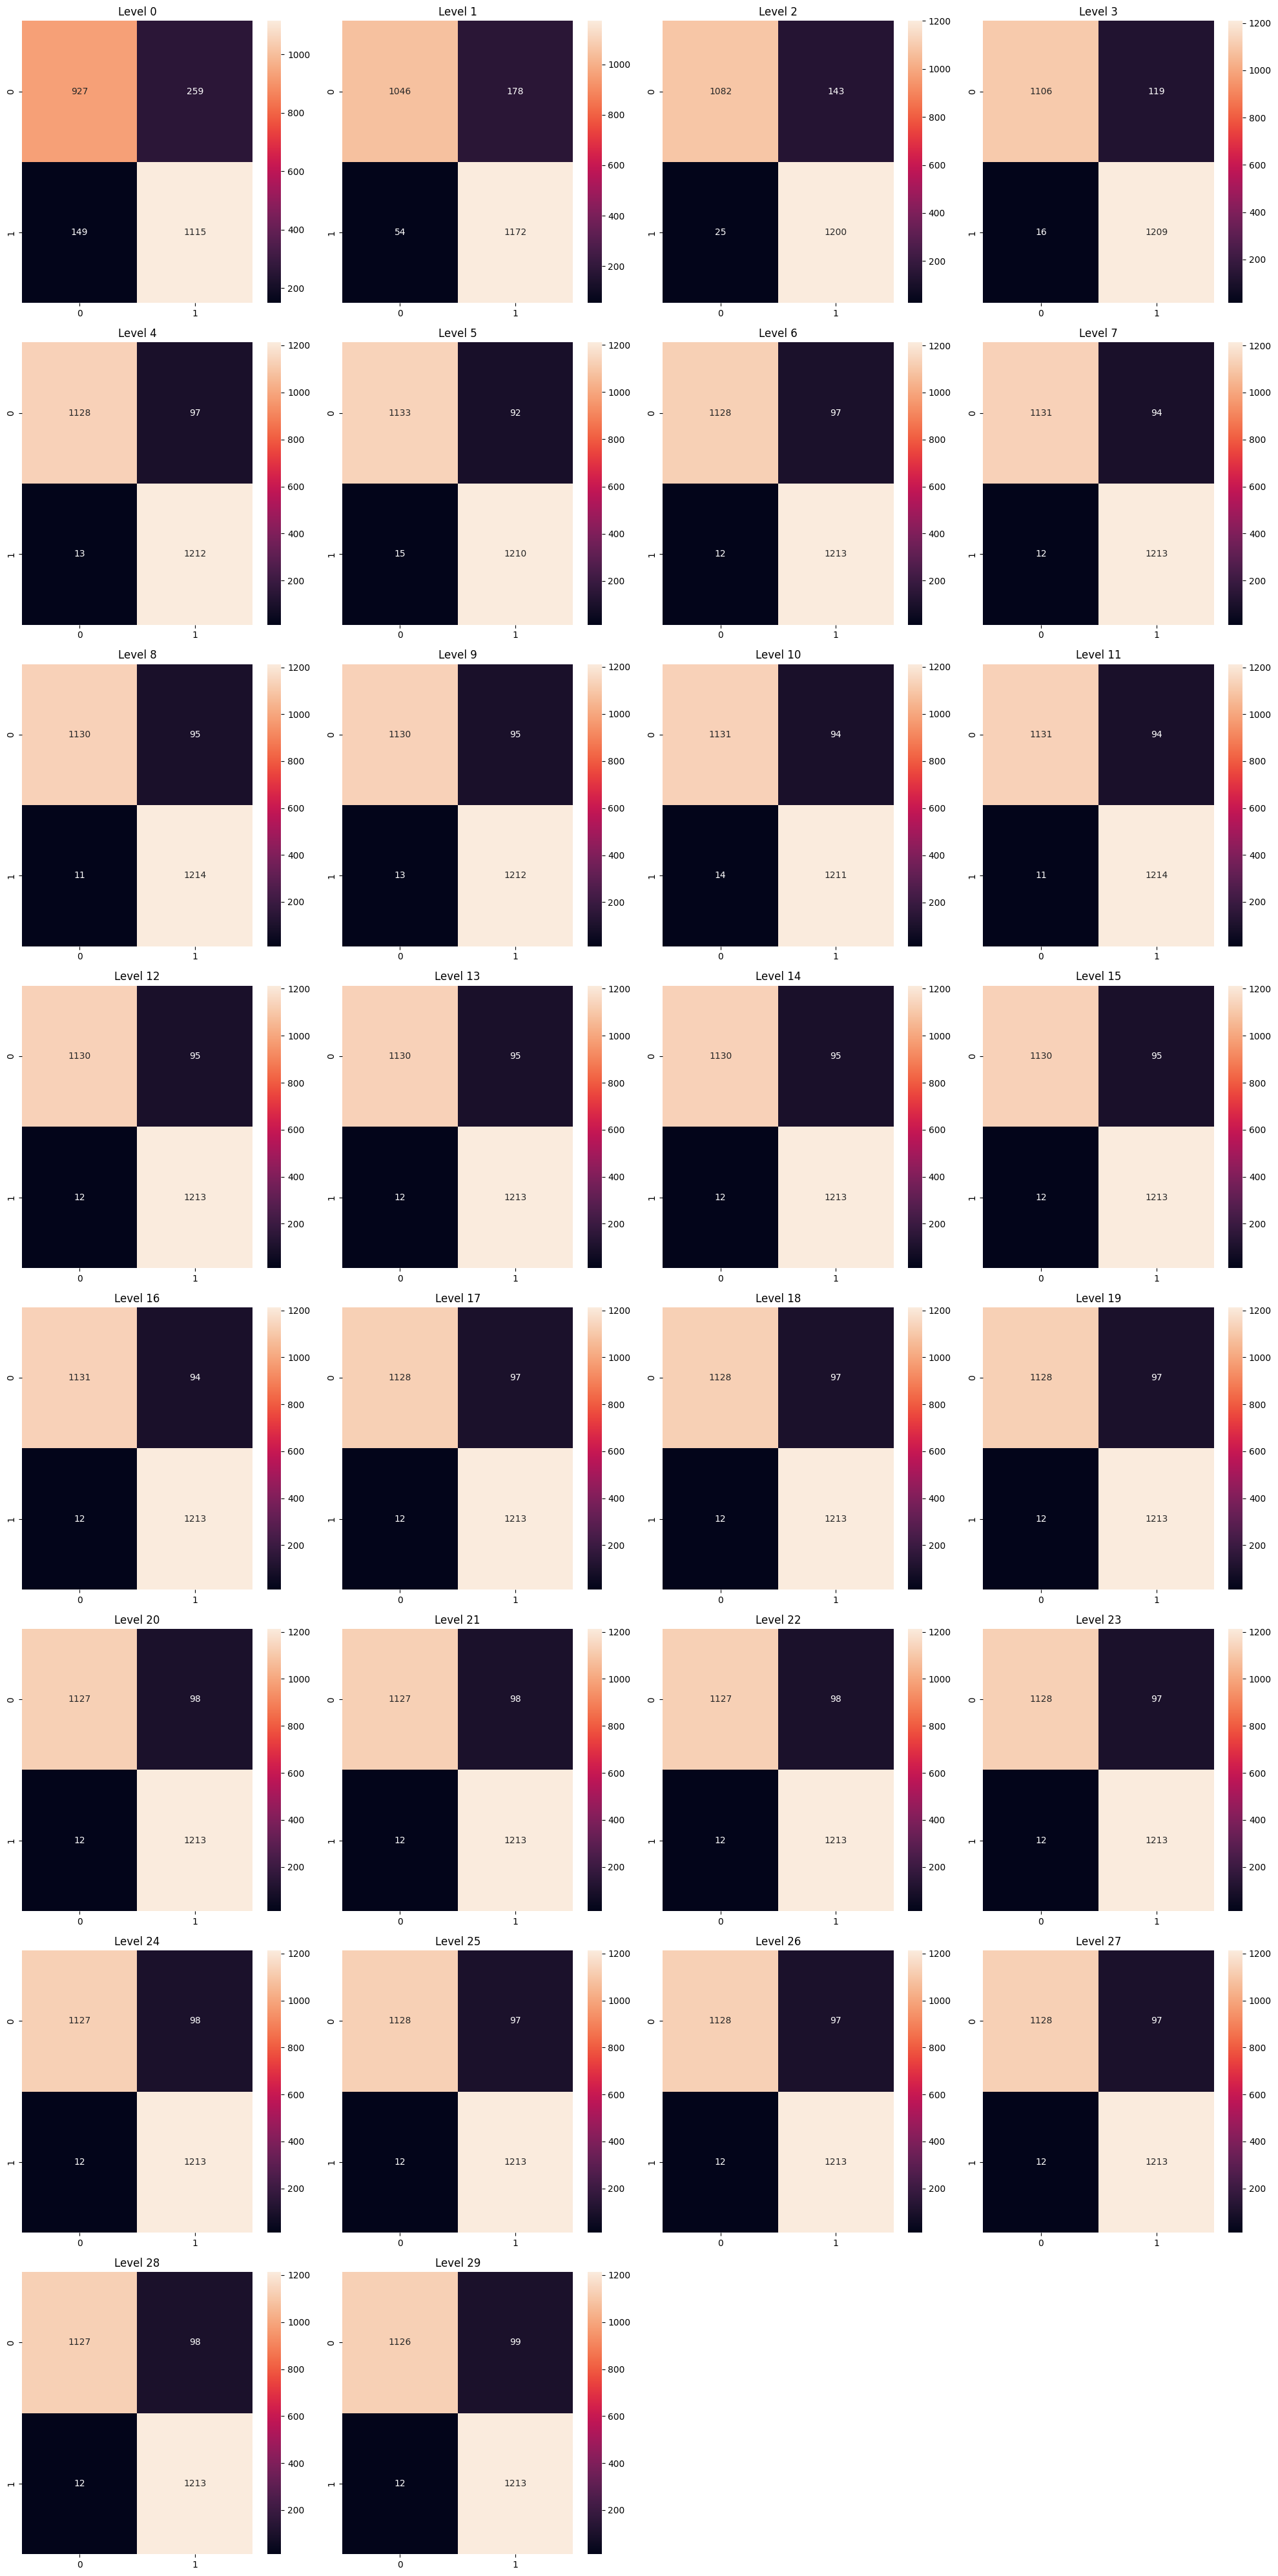

In [8]:
num_levels = len(confusion_matrices)
num_rows = (num_levels + 3) // 4
fig, ax = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))
for i in range(num_levels):
    sns.heatmap(confusion_matrices[i], annot=True, ax=ax[i // 4, i % 4], fmt='d')
    ax[i // 4, i % 4].set_title(f"Level {i}")
# Hide the empty subplots
for j in range(num_levels, num_rows * 4):
    ax[j // 4, j % 4].axis('off')
plt.tight_layout()
plt.show()

In [14]:
config = {
    "exploration_weight": 2,
    "num_simulations": 1000,
    "device": device,
    "temperature": 2,
    "stable_iterations": 10,
    "rollout_policy": "random",
    "expansion_policy": "model"
}

print(f"Taille du dataset de test : {len(test_graphs)}")

mcts_values = []
munkres_values = []
test_number = 100
for i in tqdm.tqdm(range(len(test_graphs))[:test_number]):
    matrix = np.array(test_graphs.loc[i, "cost_matrix"])
    g1 = test_graphs.loc[i, "g1"]
    g2 = test_graphs.loc[i, "g2"]
    max_depth = matrix.shape[0]
    new_matrix = augmented_matrix(matrix, matrix_size, g1, g2)
    _, value = get_mcts_cost(new_matrix, model, config, max_depth)
    mcts_values.append(value)

    munkres = Munkres()
    indexes = munkres.compute(matrix.tolist())
    munkres_values.append(sum(matrix[i][j] for i, j in indexes))


error = np.sum(np.abs(np.array(munkres_values) - np.array(mcts_values))) / test_number
print(f"Mean error: {error}")

Taille du dataset de test : 1225


100%|██████████| 100/100 [00:08<00:00, 11.33it/s]

Mean error: 1.43


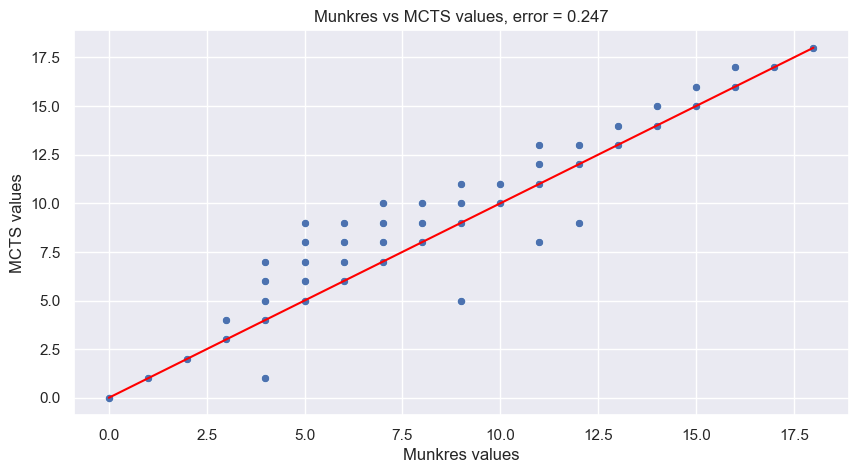

In [42]:
sns.set_theme()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=munkres_values, y=mcts_values)
plt.plot([0, max(munkres_values)], [0, max(munkres_values)], color='red')

plt.xlabel("Munkres values")
plt.ylabel("MCTS values")
plt.title(f"Munkres vs MCTS values, error = {str(error)}")
plt.show()

In [15]:
with open("processed/Linux_train.pkl", "rb") as file:
    test_graphs = pickle.load(file)

largest_matrix = 0
for i in range(len(test_graphs)):
    matrix = test_graphs.loc[i, "cost_matrix"]
    largest_matrix = max(largest_matrix, matrix.shape[0])
print(f"Largest matrix size: {largest_matrix}")

Largest matrix size: 20
